# BI Insights and Storytelling

author: Aaron Gillespie  
date: 2025-04-18

## Purpose & Context

This code base is being created in the course of completing module 6 of CSIS 44-643 from NW Missouri University. In this module we are demonstrating an understanding of the types of analysis that are done in real-world business settings. We will treat our hypothetical **smart sales** business as though it were real and needing to understand real things. The data warehouse we'll use is minimal - the one we've built over the past few weeks based in _sqlite_.

Most data explorations in the real world are done with a **purpose**. There's some goal, some *insight* that's being targeted by the data analyst for the benefit of the customer. These goals range is scope, difficulty, and level of abstraction. 

The role of the data analyist is to work from the base of the [Data-Information-Knowledge-Wisdom Pyramid](https://gillespedia.com/Data%2C+Information%2C+Knowledge%2C+Wisdom+Pyramid), synthesizing data into information, and presenting that information in a way that facilitates knowledge transfer.

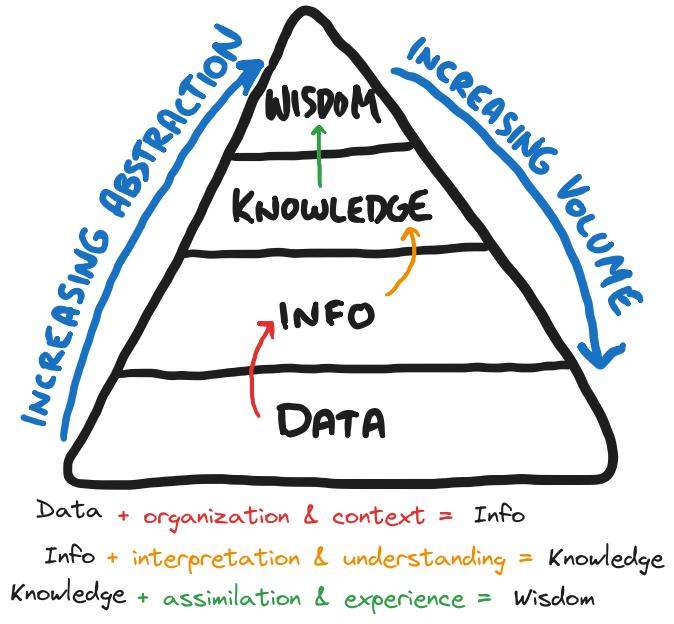

It's then up to leadership to have the wisdom to know what to do with it.

## Section 1. The Business Goal

The goals of business are typically pretty simple, in principle - how can we increase profits while reducing risk. In pursuit of these top-level abstract goals things splinter off and get increasingly complex. The business goal of a data analytics project is rarely aimed at **directly** increasing profits and reducing risk - rather it's aimed at some intermediate step assumed to be on the path toward these higher-level abstract goals.

In the case of our hypothetical "Smart Sales" business - you could imagine the following 3 goals:

1. **In which state(s) are most of our online sales take place?**  
Our online customers are located throughout the United States. If we understood which states were contributing the highest volume of sales, we might recognize potential new markets for brick-and-mortar stores.  

2. **Which stores are most dependent on supplier (X)?**  
If a particular supplier were under contract negotiation, what stores may be most impacted by changing of terms in their supplier agreement?  

3. **Which product's sales benefited most from campaign (X)?**  
If we are paying for advertising for a category of products (e.g. health), we'd like to understand which specific products saw a sales bump as a result of the advertising campaign?  

These are the goals I'll use for this analysis as a proxy for what might exist in a real-world setting. Each goal will list considerations for the analysis to-be done. 

## Section 2. Data Source

To answer these questions I will utilize the previously-prepared Data Warehouse (located in this repo at `data/dw/smart_sales.db`). I will NOT be pre-computing anything, nor will we be utilizing Spark or any other tools aimed at tackling big data-type datasets. Our data simply aren't big enough to warrant such tooling. We will, however, be utilizing the **prepared data**, rather than the raw dataset found in the `data/raw` directory.

## Section 3. Tools

For this work I'll be using a Jupyter Notebook (this one you're looking at now) with Python and some key data analysis libraries including Pandas, Seaborn, Matlibplot, and Sqlite. This choice of tooling partly reflects the nature of the challenge to be solved, and partly the environment in which I'm solving them. I am working from my personal Mac Mini, which has no pre-installed tools like PowerBI or Tableau - however no such tooling is required for this analysis. The aformentioned toolset will suffice. At this point I'm quite comfortable working with these tools.

In [115]:

# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3 as sql

# Treemaps
import squarify


## Section 4. Workflow & Logic

Approaching these on a question-by-question basis:

### 1. **In which state(s) are most of our online sales take place?**  

Here we'll simply look at the state associated with the sales. We'll also consider the date the sale took place in case sales in a given state were high in times past, but have dropped off in recent years. 

*Potential Action:* Establish new frachise locations in state

- Descriptive dimensions: state, year, month
- Numeric metric: total sales amount
- Aggregations: sum and average
- Slicing: by state
- Dicing: by year
- Drilldown: from year to month

### 2. **Which stores are most dependent on supplier (X)?**  

Here we'll join in the Suppliers into the Sales table. In order to make that join, we must also join in the intermediary table `products` which makes the breadcrumb trail possible. 
 
*Potential Action:* diversify store inventory in support of upcoming supplier negotiations to lower dependency on a given supplier

- Descriptive dimensions: store, supplier, year, month
- Numeric metric: total sales amount
- Aggregations: sum
- Slicing: by supplier
- Dicing: by store and year
- Drilldown: from year to month

### 3. **Which product's sales benefited most from campaign (X)?**  

*Potential Action:* understand advertising response for a particular product to inform future ad spend

- Descriptive dimensions: store, supplier, year, month
- Numeric metric: total sales amount
- Aggregations: sum and average
- Slicing: by supplier
- Dicing: by store and year
- Drilldown: from year to month

Since all three of our analysis goals are based on a total Sales Amount ($ figure), it's quite easy to pull **all** the relevant columns to a single data frame for our analysis. This does involve joining the `sales`, `products`, `suppliers`, and `campaigns` tables together - including a join based on a join (sales to products, then products to suppliers) - all of these can be done with a single SQL statement.

In [116]:
# Obtain Data from SQLite Data Warehouse
conn = sql.connect("/Users/aaron/Documents/Git_Repos/GradSchool/44632/smart-store-gillespie/data/dw/smart_sales.db")  # Resolve to absolute path

query = """
SELECT 
    sales.StoreID, 
    sales.CampaignID, 
    sales.SaleAmount, 
    sales.SaleDate, 
    sales.StateCode, 
    sales.ProductID, 
    products.Supplier, 
    products.ProductName, 
    suppliers.SupplierName, 
    stores.StoreName, 
    campaigns.CampaignName
FROM sales
JOIN products ON sales.ProductID = products.ProductID
JOIN suppliers ON products.Supplier = suppliers.SupplierID
JOIN stores ON sales.StoreID = stores.StoreID
JOIN campaigns ON sales.CampaignID = campaigns.CampaignID
"""

df = pd.read_sql_query(query, conn)
conn.close()
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['Year'] = df['SaleDate'].dt.year
df['Month'] = df['SaleDate'].dt.month

# Data Exploration
print("HEAD:")
print(df.head())
print("INFO:")
print(df.info())

HEAD:
   StoreID  CampaignID  SaleAmount   SaleDate StateCode  ProductID  Supplier  \
0      404           0       39.10 2024-01-06        CA        102      1001   
1      403           0       19.78 2024-01-06        TX        105      1004   
2      404           0      335.10 2024-01-16        FL        107      1006   
3      406           0      195.50 2024-01-16        NY        102      1001   
4      405           0      117.30 2024-01-25        PA        102      1001   

  ProductName SupplierName    StoreName CampaignName  Year  Month  
0      hoodie         Bike  Springfield      Podcast  2024      1  
1    football      Balding     Downtown      Podcast  2024      1  
2      jacket      Carhurt  Springfield      Podcast  2024      1  
3      hoodie         Bike         Gary      Podcast  2024      1  
4      hoodie         Bike        Plano      Podcast  2024      1  
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 13 column

At this point we have a single Pandas Dataframe that can be used to generate visualizations for all three of our analysis goals. 

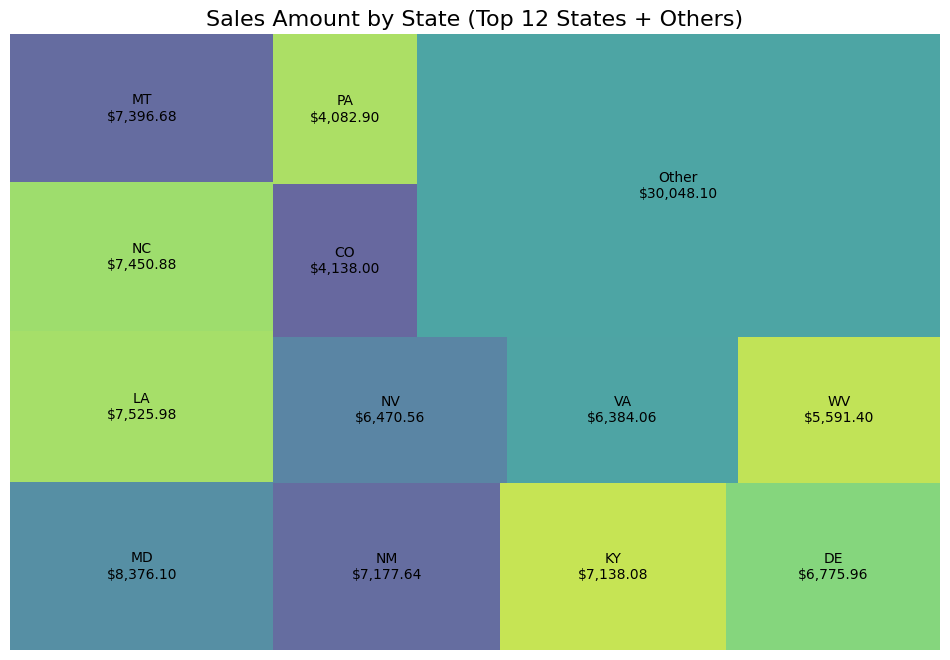

In [117]:

# Aggregate sales by StateCode
state_sales = df.groupby('StateCode')['SaleAmount'].sum().sort_values(ascending=False)

# Separate top 12 states and group the rest as "Other"
top_states = state_sales.head(12)
other_states = state_sales.iloc[12:].sum()
top_states['Other'] = other_states

# Prepare data for the treemap
labels = [f"{state}\n${sales:,.2f}" for state, sales in top_states.items()]
sizes = top_states.values

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.title("Sales Amount by State (Top 12 States + Others)", fontsize=16)
plt.axis('off')
plt.show()

That Treemap shows total volume of sales **for all time**. We are interested in making a business decisions *today*, so we may consider what's happened **more recently**. We'll do this by filtering the `sales` dataset to only those sales since Q3 of calendar year 2024.

In [118]:
# Filter the dataset for sales on or after July 1st, 2024
filtered_df = df[df['SaleDate'] >= pd.to_datetime('2024-07-01')]

# Ensure the dataframe was filtered correctly
print(f"Total rows in df: {len(df)}")
print(f"Total rows in filtered_df: {len(filtered_df)}")


Total rows in df: 94
Total rows in filtered_df: 38


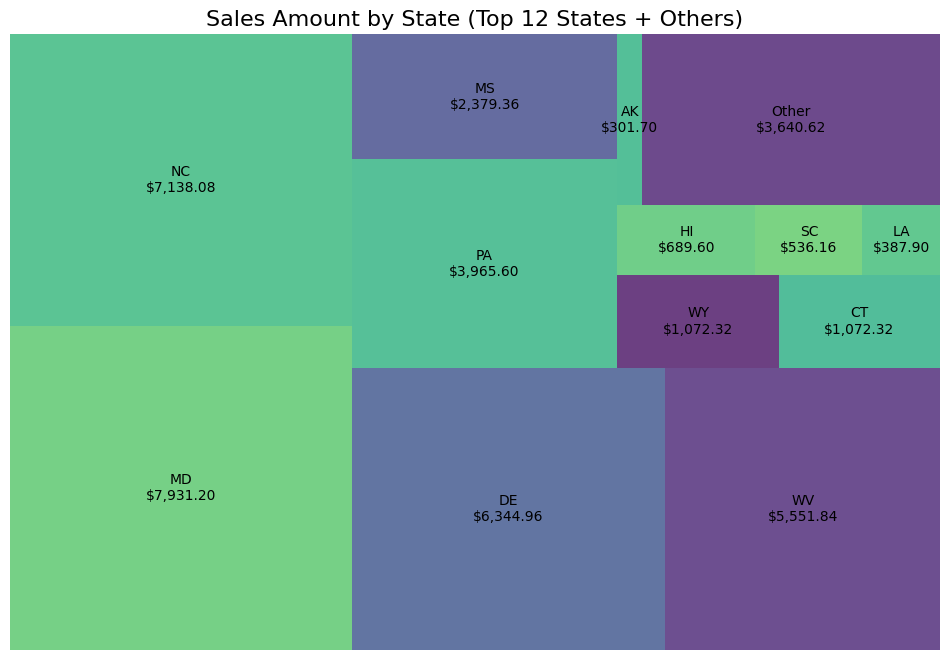

In [119]:

# Aggregate sales by StateCode
state_sales = filtered_df.groupby('StateCode')['SaleAmount'].sum().sort_values(ascending=False)

# Separate top 12 states and group the rest as "Other"
top_states = state_sales.head(12)
other_states = state_sales.iloc[12:].sum()
top_states['Other'] = other_states

# Prepare data for the treemap
labels = [f"{state}\n${sales:,.2f}" for state, sales in top_states.items()]
sizes = top_states.values

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.title("Sales Amount by State (Top 12 States + Others)", fontsize=16)
plt.axis('off')
plt.show()

That will give us enough for question #1.

On to question 2 regarding stores & suppliers.

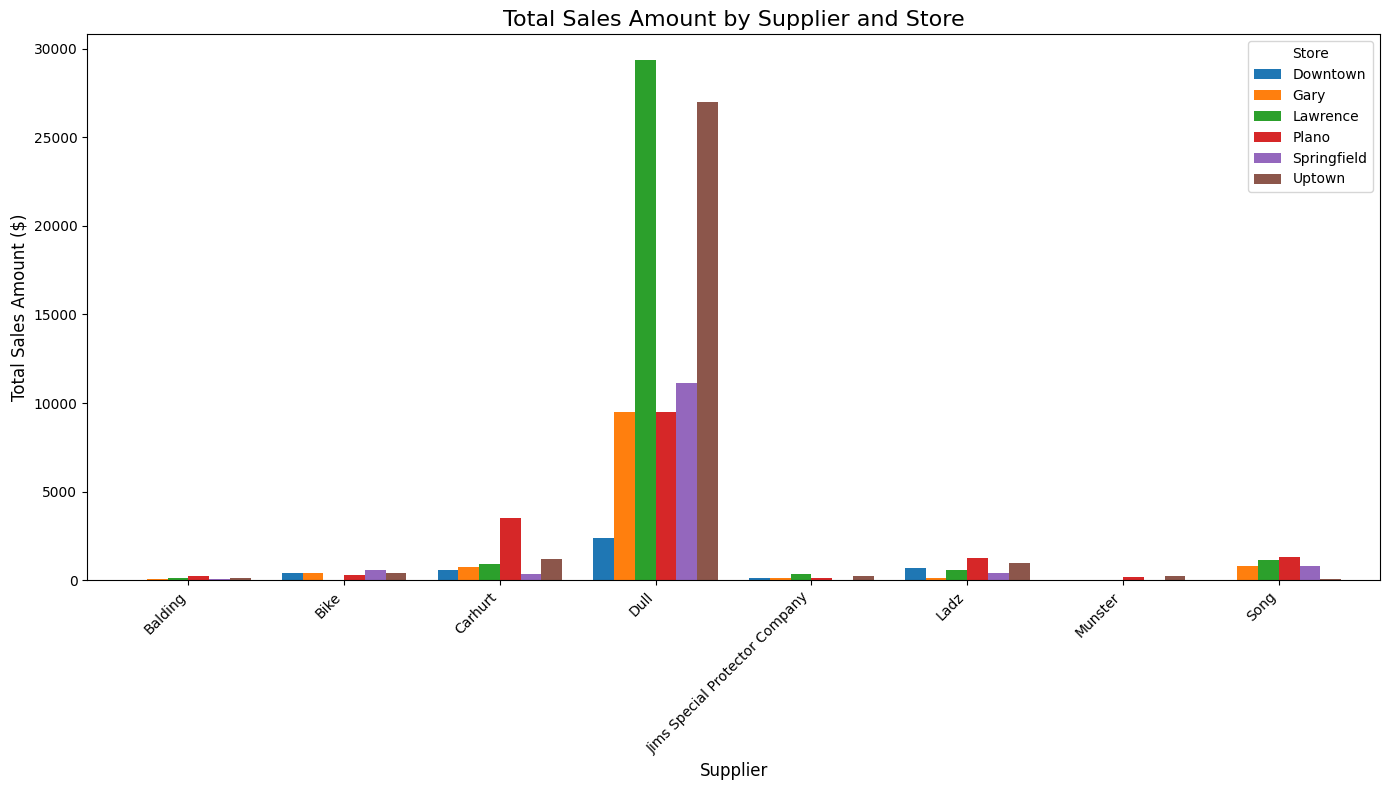

In [120]:
# Aggregate sales by Supplier and StoreName
supplier_store_sales = df.groupby(['SupplierName', 'StoreName'])['SaleAmount'].sum().unstack()

# Plot the grouped bar chart
supplier_store_sales.plot(kind='bar', figsize=(14, 8), width=0.8)

# Customize the chart
plt.title("Total Sales Amount by Supplier and Store", fontsize=16)
plt.xlabel("Supplier", fontsize=12)
plt.ylabel("Total Sales Amount ($)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="Store", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

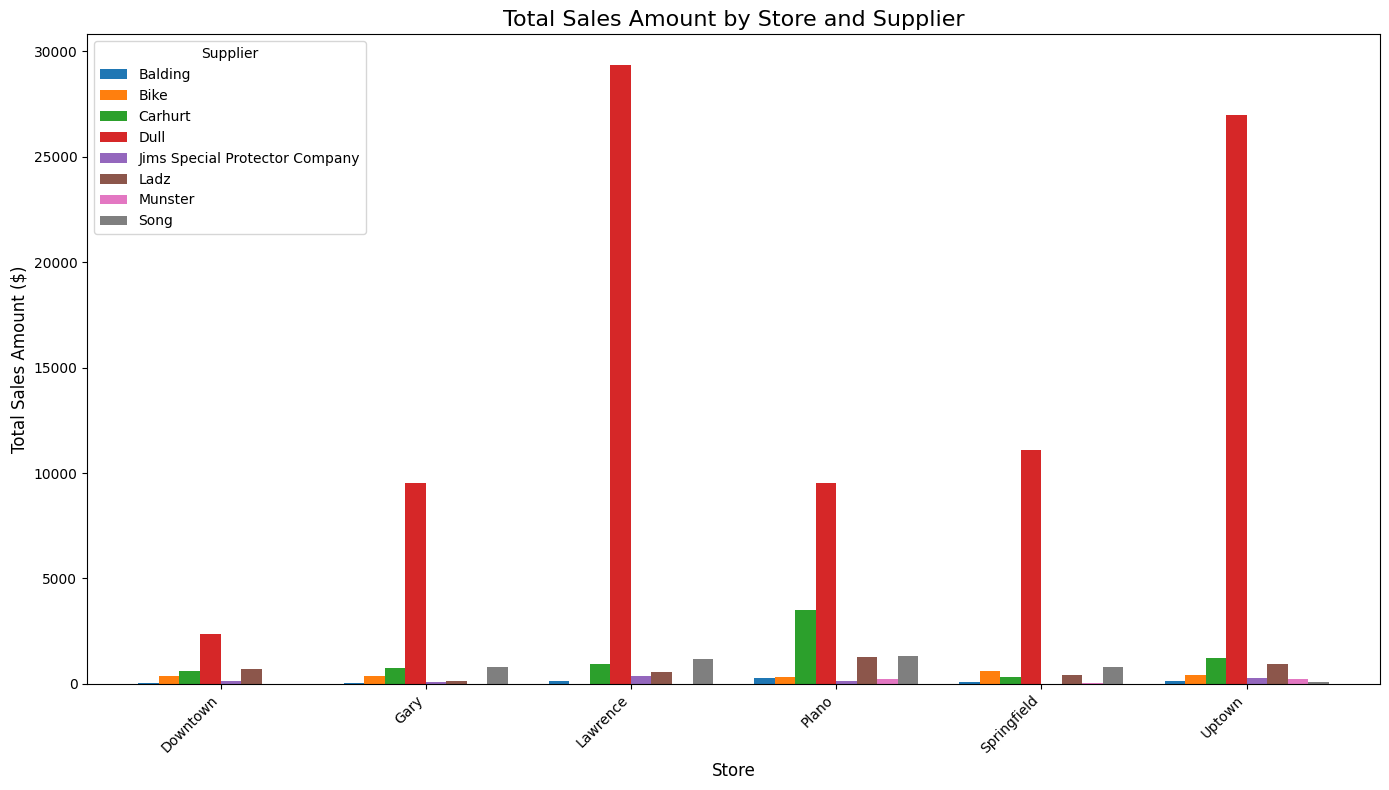

In [121]:
# Transpose the DataFrame to switch rows and columns
store_supplier_sales = supplier_store_sales.T

# Plot the grouped bar chart
store_supplier_sales.plot(kind='bar', figsize=(14, 8), width=0.8)

# Customize the chart
plt.title("Total Sales Amount by Store and Supplier", fontsize=16)
plt.xlabel("Store", fontsize=12)
plt.ylabel("Total Sales Amount ($)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title="Supplier", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Well turns out this may have not been the best hypothetical question to use for the dataset I was given. This is essentially what were looking for, though. 

On to question 3 regarding products and campaign IDs

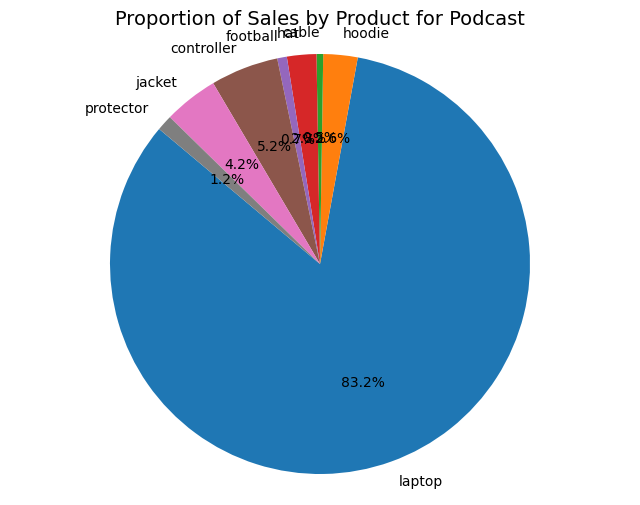

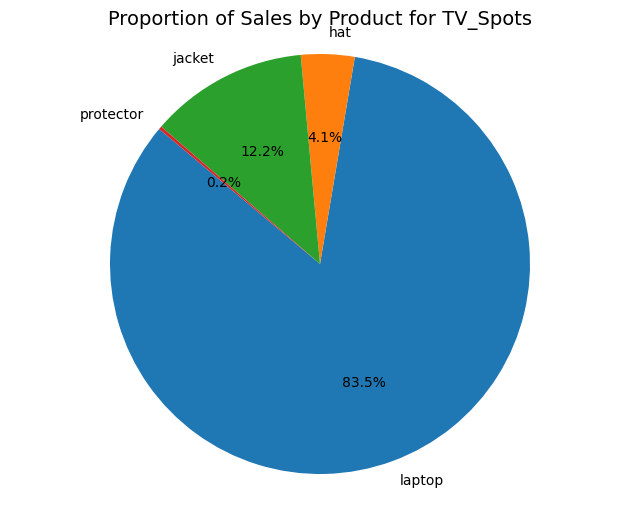

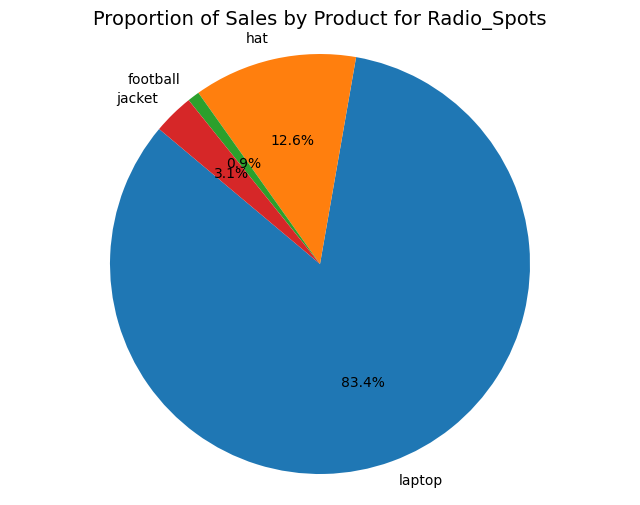

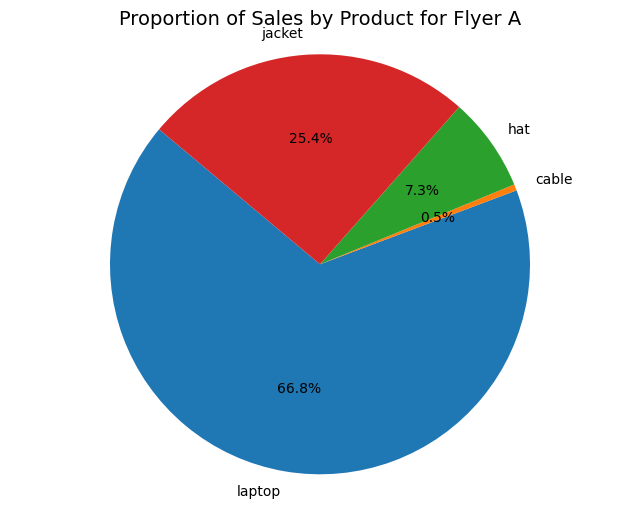

In [122]:
# Group data by CampaignID and ProductID, summing the SaleAmount
campaign_product_sales = df.groupby(['CampaignID', 'ProductID', 'ProductName', 'CampaignName'])['SaleAmount'].sum().reset_index()
# Map CampaignID to CampaignName
campaign_product_sales = campaign_product_sales.merge(df[['CampaignID', 'CampaignName']].drop_duplicates(), on='CampaignID', how='left')
# Iterate through each CampaignID to create a pie chart
unique_campaigns = campaign_product_sales['CampaignID'].unique()

for campaign_id in unique_campaigns:
    # Filter data for the current CampaignID
    campaign_data = campaign_product_sales[campaign_product_sales['CampaignID'] == campaign_id]
    # Get the CampaignName for the current CampaignID
    campaign_name = campaign_data['CampaignName_x'].iloc[0]


    # Prepare data for the pie chart
    labels = campaign_data['ProductName']
    sizes = campaign_data['SaleAmount']
    
    # Create the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Proportion of Sales by Product for {campaign_name}", fontsize=14)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()

This gives us enough to star to answer the 3rd analysis goal. 

## Section 5: Results

The three questions being investigated here are all some variation of slicing & dicing based on `SalesAmount`. The results for each are below.

### 1. **In which state(s) are most of our online sales take place?**  

Considering every sale in the dataset, the higest revenue states were:

1. Minnesota
2. North Carolina
3. Louisiana
4. Maryland
5. New Mexico

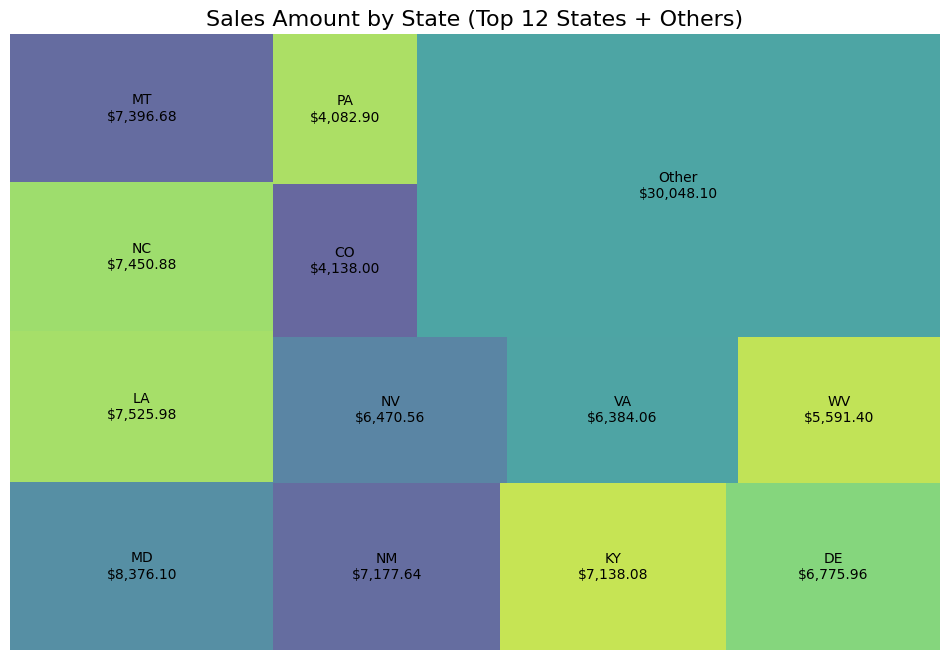

Considering only those states which have trended higher in the most recent year (i.e. since July 2024), the results are slightly different:

1. North Carolina
2. Maryland
3. Deleware
4. Pennsylvania
5. West Virginia

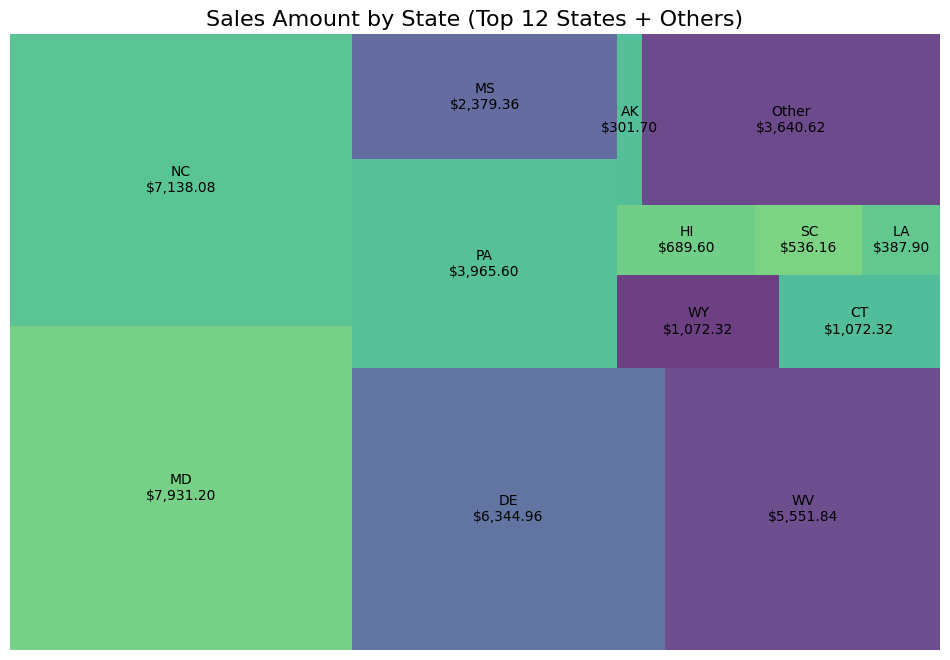

Taking this into account - the online sales are strongest in North Carolina and Maryland both overall and when considering only recent sales. If you were looking to place brick and mortar stores in new states, you might start considering sub-dividing the markets within these states to look for a favorable real-estate in cities in those two states. 

### 2. **Which Stores are most depend on supplier (X)?**

While this was the original question that was asked, the results indicate another factor that cannot be ignored - the supplier named **Dull** makes up the absolute bulk of the sales, almost regardless of which store you consider. If the original business need was to inform coming contract negotiations, you'd immediately need to start preparations for any negotiation including the supplier named **Dull**. Any other supplier is on the chopping block compared to them. 

That said, the original ask was to look at **stores** that depend on any given supplier. While every store depends on **Dull**, there is a store that depends in a disproportionate way (compared to other stores) on a given supplier - the store in Plano, TX is selling more product sourced from **Carhurt** than the other stores. Thus, if negotiations are going poorly with the vendor for off-brand coats, you may need to bolster other product lines in Plano, TX to make up for those **Carhurt Coats** with some genuine brand *Carharts* sourced from the real deal.

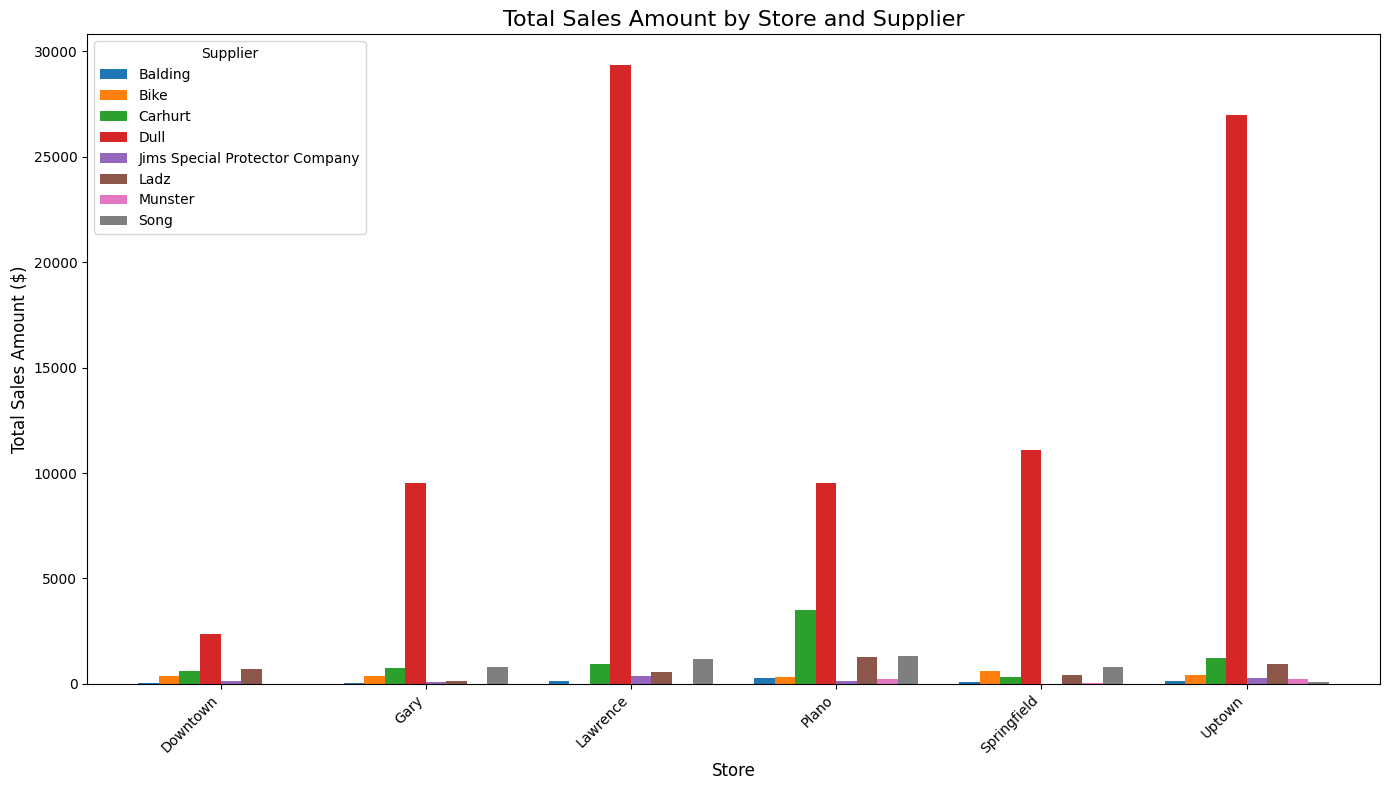

Honestly if this were a real-world dataset I'd start suggesting we consider the 80/20 analysis of the overhead we spend working with suppliers *other than* Dull. If we could remove all that overhead and still maintain 90% of our sales, that could very well be a worthwhile trade-off (recognizing this also assumes the risk of being bound to the success of this one supplier). 

### 3. **Which products' sales benefitted most from campaign (X)?**

This is another case of one question going in, but an overwhelming and unexpected result coming out. The sales from **every** campaign were dominated by *laptop* revenue. Given more time for analysis, I'd try to normalize the sales to present a view based on units sold while running one campaign compared to units sold **not** running that campaign. This could isolate the effect of the campaign itself, and compare the sales to the *base rate**. This would make Daniel Kahneman happier, for sure. This is also another case of considering alternative conclusions from the quesiton that was asked. An ethical data analyst would be obliged to ensure that leadership both received the answer to the question that was asked any any other insight that could benefit the company and the stockholders (this assumes rising company value = good ethics, which is an assumption that's always worth more scruitiny than I'll give it here). 

Now, again, the original ask was to do with what products benefited from any given campaign. The one campaign that sicks out in terms of changing the ratio of revenue was `Flyer A`, the bottom-most pie chart. This campaign resulted in a disproportionately high jackets & hats, seemingly. Again given more time I'd check to see whether this is true, or if the campaign actually resulted in a disproportionately *lower* volume of sales of laptops, our cash cow. 

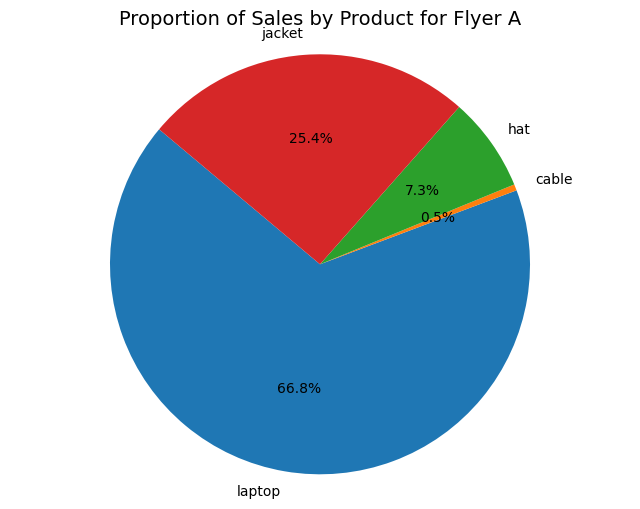

If we had a particularly high profit margin on our apparel, `Flyer A` seems like a promising bit of advertising spend for the future. 

## Section 6. Suggested Business Action

The business I've created for this fictious bit of analysis is strange. I'd suggest a narrower line of business offhand without any analysis, but as a result of the analysis and the above-drawn conclusions we can summarize our suggestion business actions thusly:

1. If you're looking to build new brick-and-mortar locations to supplement online sales, you may be best advised to go with North Carolina and Maryland.
2. If you're about to negotiate with the business named **Carhurt**, know that your store in Plano, TX is the one that's most likely to be effected (positively or negatively) with the results of those negotiations.
   1. If you're about to negotiate with the business named **Dull**, you best bring your most competent negotiators because that's the most critical negotiation we have in terms of sales volume.
3. If you're interested in selling more apparel (namely hats and jackets), the flyer we used in the `Flyer A` campaign resulted in the highest proportion of hats & jackets sold as a fraction of total sales.

## Section 7. Challenges

The most challenging aspect of this assignment was actually the relatively small sample size of the data I worked with, and my choices very early on for the arbitrary set of columns to add to the data. We are doing analysis on **93 rows**. When your sample is small enough, individual rows can carry a lot of signal. The disproportionate cost of the *laptop* drown out some of the trends that would otherwise have been easier to see. For example - the laptop supplier was the dominate supplier, and the laptop itself dominated every pie chart for the campaigns. This loud signal crowded out what would probably have made for a more interesting set of conclusions if it were similarly priced to the other goods. 

Given the opportunity to create this dataset and anaylsis all over again I'd have come up with a reasonable-yet-fictious column called "profit" and based all my analysis on *that*, rather than sales volume. The expensive-per-unit laptop and its associated suppliers/campaigns dominated the charts and graphics.

Probably the most difficult technical challenge was the syntax to make the pie charts show the **names** of the products and campaigns rather than their respective `ProductID` and `CampaignID`. This analysis required the use of their *ID*s, but the the charts benefitted from the use of their human-friendly names. For whatever reason this this was the most tedious part to get right. In this case I worked with copilot in my VS Code instance to incrementally build the dataset and visualizations toward what I wanted them to be. 